<a href="https://colab.research.google.com/github/shobhittya/deeplearning/blob/main/CelebA_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jessicali9530/celeba-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


  1%|          | 7.00M/1.33G [00:00<00:21, 66.0MB/s]

100%|██████████| 1.33G/1.33G [00:09<00:00, 156MB/s]


In [8]:
import os

DATA_DIR = './celeba-dataset/img_align_celeba'
print(os.listdir(DATA_DIR))

['img_align_celeba']


In [9]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [10]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [11]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


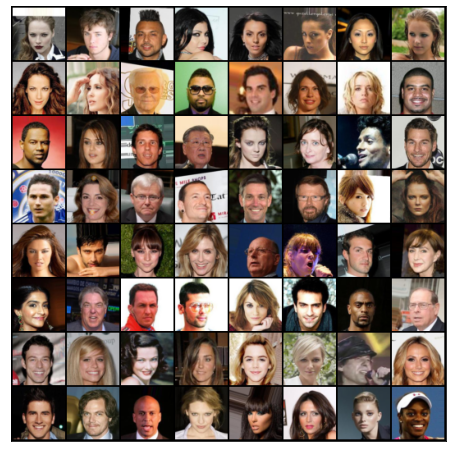

In [15]:
show_batch(train_dl)

In [16]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 71kB 5.4MB/s 


In [17]:
import jovian

In [18]:
jovian.commit(project='CelebA', environment=None)

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab


In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)

In [22]:
import torch.nn as nn

In [23]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [24]:
discriminator = to_device(discriminator, device)

In [25]:
latent_size = 128

In [26]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


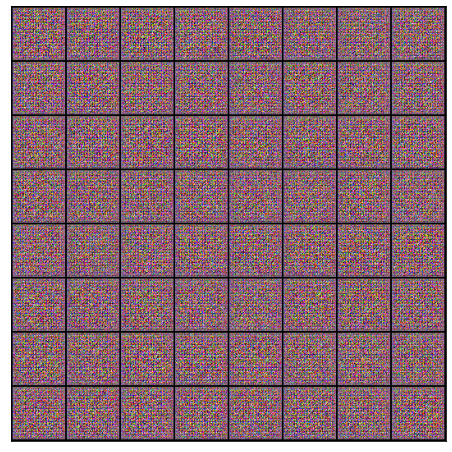

In [27]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [28]:
generator = to_device(generator, device)

In [29]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [30]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [31]:
from torchvision.utils import save_image

In [32]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [33]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [34]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


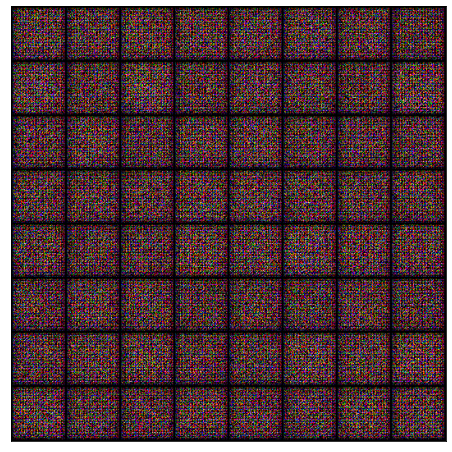

In [35]:
save_samples(0, fixed_latent)

In [36]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [37]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [38]:
lr = 0.0002
epochs = 25

In [39]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/25], loss_g: 3.6756, loss_d: 0.5059, real_score: 0.8157, fake_score: 0.2216
Saving generated-images-0001.png



Epoch [2/25], loss_g: 2.9977, loss_d: 0.2926, real_score: 0.9108, fake_score: 0.1653
Saving generated-images-0002.png



Epoch [3/25], loss_g: 2.1054, loss_d: 0.5375, real_score: 0.8019, fake_score: 0.2410
Saving generated-images-0003.png



Epoch [4/25], loss_g: 3.2628, loss_d: 0.2254, real_score: 0.9442, fake_score: 0.1408
Saving generated-images-0004.png



Epoch [5/25], loss_g: 3.0342, loss_d: 0.2122, real_score: 0.8718, fake_score: 0.0592
Saving generated-images-0005.png



Epoch [6/25], loss_g: 3.8208, loss_d: 0.0668, real_score: 0.9822, fake_score: 0.0453
Saving generated-images-0006.png



Epoch [7/25], loss_g: 2.5347, loss_d: 0.3804, real_score: 0.7764, fake_score: 0.0757
Saving generated-images-0007.png



Epoch [8/25], loss_g: 3.4002, loss_d: 0.2593, real_score: 0.8905, fake_score: 0.1089
Saving generated-images-0008.png



Epoch [9/25], loss_g: 4.5308, loss_d: 0.2385, real_score: 0.9629, fake_score: 0.1626
Saving generated-images-0009.png



Epoch [10/25], loss_g: 3.8610, loss_d: 0.0831, real_score: 0.9679, fake_score: 0.0461
Saving generated-images-0010.png



Epoch [11/25], loss_g: 3.4077, loss_d: 0.2935, real_score: 0.7806, fake_score: 0.0057
Saving generated-images-0011.png



Epoch [12/25], loss_g: 4.3896, loss_d: 0.1060, real_score: 0.9344, fake_score: 0.0282
Saving generated-images-0012.png



Epoch [13/25], loss_g: 2.3112, loss_d: 0.2801, real_score: 0.8021, fake_score: 0.0156
Saving generated-images-0013.png



Epoch [14/25], loss_g: 4.7788, loss_d: 0.1069, real_score: 0.9775, fake_score: 0.0762
Saving generated-images-0014.png



Epoch [15/25], loss_g: 3.7727, loss_d: 0.1347, real_score: 0.9243, fake_score: 0.0405
Saving generated-images-0015.png



Epoch [16/25], loss_g: 4.7205, loss_d: 0.1850, real_score: 0.9027, fake_score: 0.0562
Saving generated-images-0016.png



Epoch [17/25], loss_g: 3.7713, loss_d: 0.1288, real_score: 0.9397, fake_score: 0.0553
Saving generated-images-0017.png



Epoch [18/25], loss_g: 5.3422, loss_d: 0.1164, real_score: 0.9455, fake_score: 0.0493
Saving generated-images-0018.png



Epoch [19/25], loss_g: 4.1833, loss_d: 0.0876, real_score: 0.9532, fake_score: 0.0342
Saving generated-images-0019.png



Epoch [20/25], loss_g: 6.1300, loss_d: 0.2747, real_score: 0.9668, fake_score: 0.1731
Saving generated-images-0020.png



Epoch [21/25], loss_g: 5.5455, loss_d: 0.0561, real_score: 0.9776, fake_score: 0.0307
Saving generated-images-0021.png



Epoch [22/25], loss_g: 5.4248, loss_d: 0.0827, real_score: 0.9750, fake_score: 0.0507
Saving generated-images-0022.png



Epoch [23/25], loss_g: 5.3819, loss_d: 0.1503, real_score: 0.9780, fake_score: 0.0966
Saving generated-images-0023.png



Epoch [24/25], loss_g: 4.7428, loss_d: 0.0888, real_score: 0.9453, fake_score: 0.0284
Saving generated-images-0024.png



Epoch [25/25], loss_g: 7.4573, loss_d: 0.4360, real_score: 0.9938, fake_score: 0.2623
Saving generated-images-0025.png


In [41]:
losses_g, losses_d, real_scores, fake_scores = history

In [42]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [43]:
from IPython.display import Image

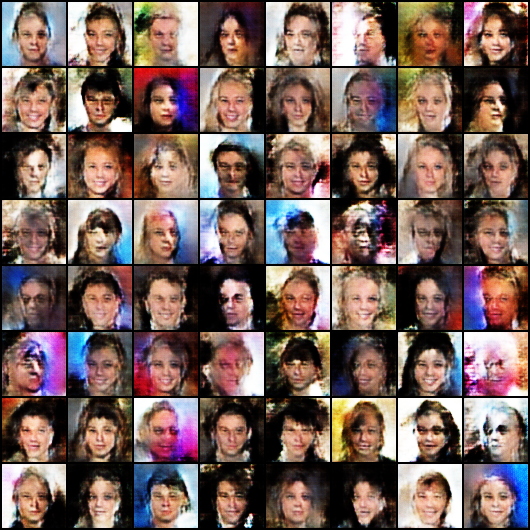

In [44]:
Image('./generated/generated-images-0001.png')

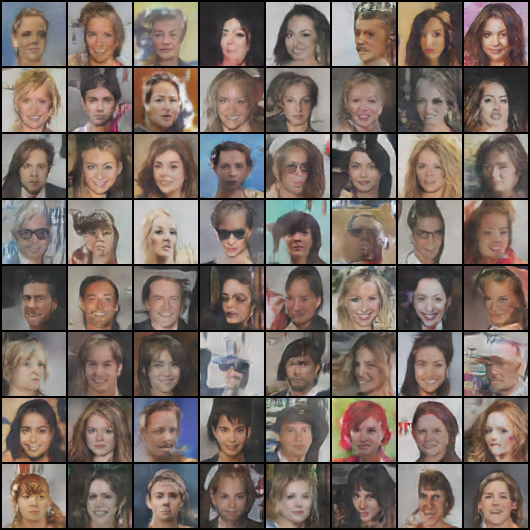

In [45]:
Image('./generated/generated-images-0010.png')

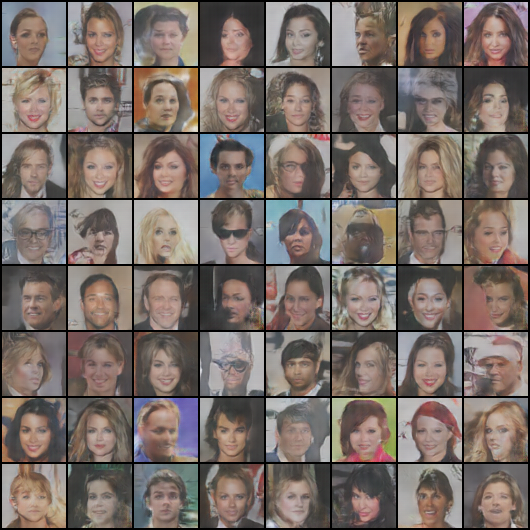

In [46]:

Image('./generated/generated-images-0020.png')

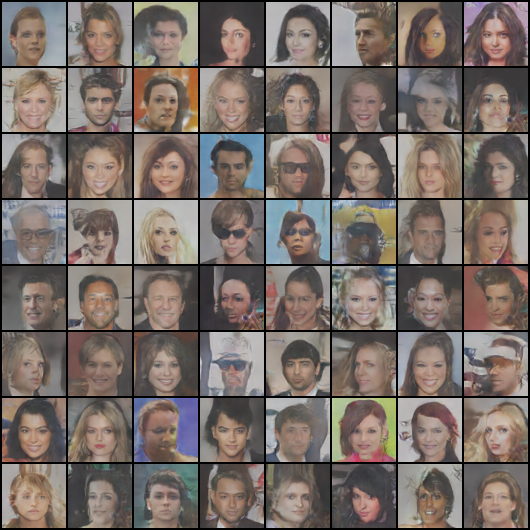

In [50]:
Image('./generated/generated-images-0024.png')

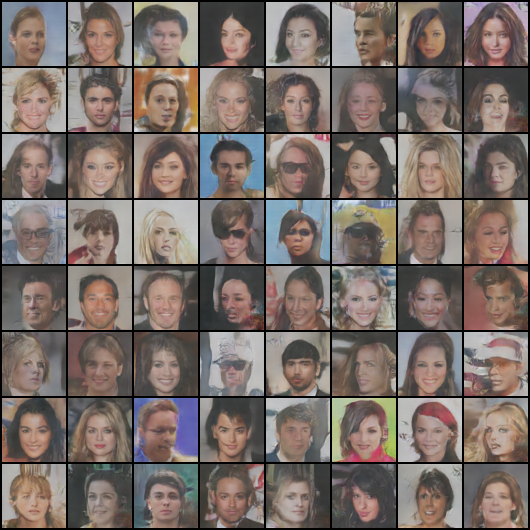

In [51]:
Image('./generated/generated-images-0025.png')

In [52]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

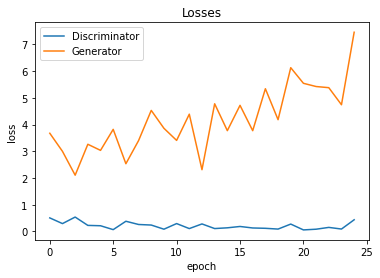

In [53]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

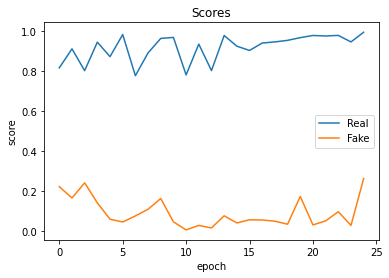

In [54]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [55]:
import jovian

In [57]:
jovian.commit(project='CelebA', 
              outputs=['G.pth', 'D.pth', 'gans_training.avi'], 
              environment=None)

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab
